In [27]:



import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
    shutil.rmtree('logs')
except:
    pass

## Task 2: Create Dataset

In [28]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [29]:
def create_example(x, y):
    c = np.random.randint(0, 2)
    
    image = 0.5 * np.random.rand(28, 28, 3)
    
    image[:, :, c] += 0.5 *x / 255
    return image, y, c

digit : 0, color: red


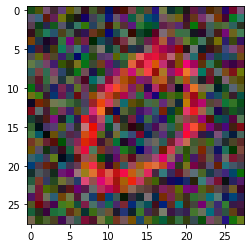

In [30]:
colors = {0: 'red', 1 : "grean"}

x, y, c = create_example(x_train[1], y_train[1])
print(f'digit : {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

## Task 3: Dataset Generator

In [31]:

def generate_data(x, y, batch_size = 32):
    num_examples = len(y)

    while True :
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))

        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, digit, color = create_example(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color

        yield x_batch, [y_batch, c_batch]

In [32]:

x, [y, c] = next(generate_data(x_test, y_test, 1))

[0.] [1.]


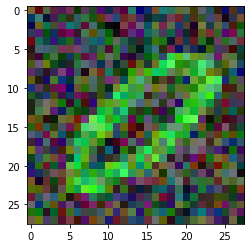

In [33]:
print(y,c)
plt.imshow(x[0])

## Task 4: Create Model

In [34]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

# First the input layer
input_ = Input(shape=(28,28,3), name = 'input')

# First convolution layer
conv_1 = Conv2D(32, 3,  name = 'conv_1')(input_)
# activation layer
act_1 = Activation('relu', name = 'act_1')(conv_1)

# Maxpool layer
pool_1 = MaxPool2D(4,name = 'pool_1')(act_1)
# Flatten layer
flat_1 = Flatten(name = 'flat_1')(pool_1)

# First Output Layer
color =  Dense(1,activation = 'sigmoid', name = 'color')(flat_1)

# Second convolution layer
conv_2 = Conv2D(32, 3, padding = 'same', name = 'conv_2')(act_1)
# activation layer
act_2 = Activation("relu", name='act_2')(conv_2)

# Third convolution layer
conv_3 = Conv2D(32, 3, padding = 'same', name = 'conv_3')(act_2)

# Add Layer : 
# connect the first convolution layer's output with the output of the thired convolution layer and add both.  
add = Add(name = 'add')([act_1, conv_3])

# activation layer
act_3 = Activation("relu", name='act_3')(add)

# maxpool layer
pool_2 = MaxPool2D(4, name = 'pool_2')(act_3)
# flatten layer
flat_2 = Flatten(name = "flat_2")(pool_2)

# Our Secound Output layers
digit = Dense(10, activation = 'softmax', name = 'digit')(flat_2)

# Create the model
model = tf.keras.models.Model(input_, [digit, color])

# Compile the model
model.compile(
              # since we have two output layer, we can define two loss function  
              loss = {
                  'digit' : 'sparse_categorical_crossentropy',
                  'color' : 'binary_crossentropy'
              }, 
              optimizer = 'adam',
              metrics = ['accuracy']
)
# To view the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 26, 26, 32)   896         ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 26, 26, 32)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 26, 26, 32)   9248        ['act_1[0][0]']                  
                                                                                            

## Task 5: Training the Model

In [10]:


class Logger(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # get the output accuracy
        digit_accuracy = logs.get('digit_accuracy')
        color_accuracy = logs.get('color_accuracy')
        
        # get the verbos accuracy
        val_digit_accuracy = logs.get('val_digit_accuracy')
        val_color_accuracy = logs.get('val_color_accuracy')
        
        # print the log
        print('='*30, epoch + 1, '='*30)
        print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
        print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [36]:
from types import TracebackType

train_gen = generate_data(x_train,y_train)
test_gen = generate_data(x_test,y_test)

_ = model.fit(
    train_gen,
    validation_data = test_gen,
    steps_per_epoch = 250,
    validation_steps = 100,
    epochs =20,
    callbacks = [
                 Logger(),
                 tf.keras.callbacks.TensorBoard(log_dir='./logs')
                  ],
 verbose=0
          
)

============================== 1 ==============================
digit_accuracy: 0.65, color_accuracy: 0.98
val_digit_accuracy: 0.88, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.92, color_accuracy: 1.00
val_digit_accuracy: 0.95, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.97, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 7 ===================

## Task 6: Final Predictions

In [37]:
def test_model(show=True):
  x, [y, c] = next(test)
  
  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])
  
  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

GT: 2, grean
Pr: 2, grean


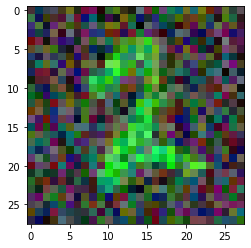

In [38]:
test_model()

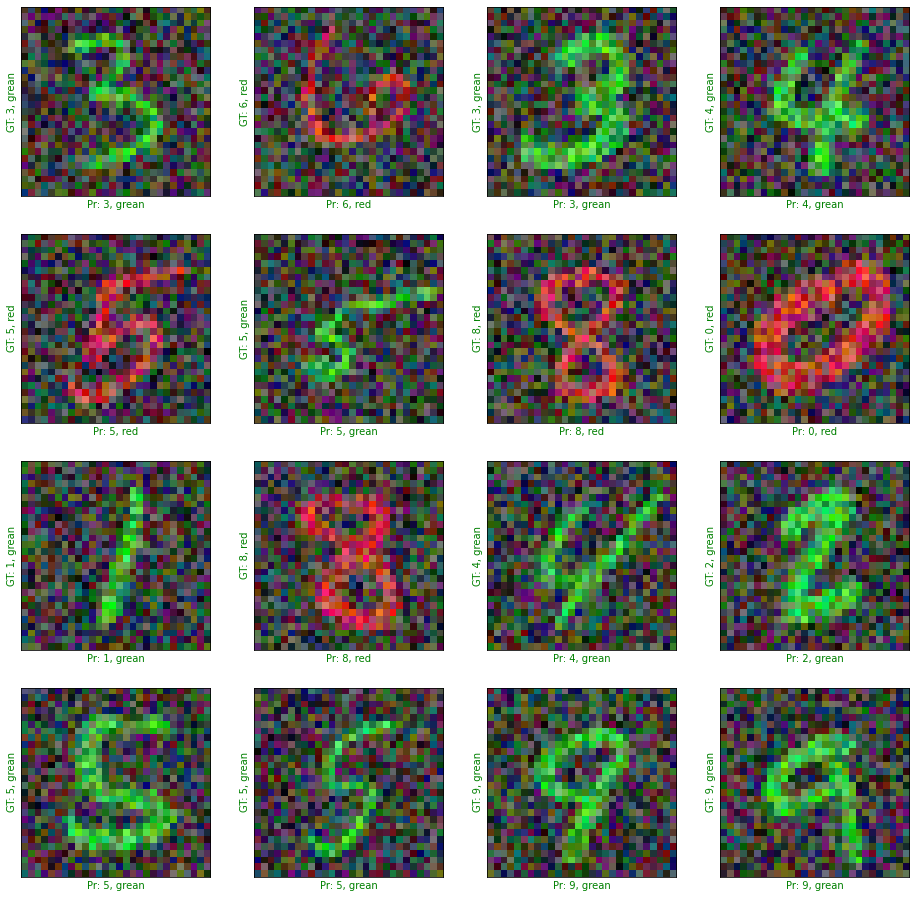

In [41]:
# Generate in a 4x4 matrix

plt.figure(figsize = (16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    test_model(show = False)
plt.show()